Check Python version

In [239]:
!python --version

Python 3.10.6


Import libraries

In [240]:
import json
import yaml
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### **Extract Data**

In [241]:
# Local directory
data_dir = "../datasets/climate"
file_name = "temp_anom_w_forcing"
#data_dir = "../datasets/finance"
#file_name = "Returns_short_interest_data_train"
file_path = f"{data_dir}/{file_name}.csv"

# Through online GitHub
# file_path = "https://github.com/ourownstory/neuralprophet-data/raw/main/datasets/air_passengers.csv"

In [242]:
dataset = pd.read_csv(file_path)

In [243]:
dataset.shape

(163, 11)

In [244]:
dataset.columns

Index(['Year', 'WMGHG', 'Ozone', 'Solar', 'Land_Use', 'SnowAlb_BC', 'Orbital',
       'TropAerDir', 'TropAerInd', 'StratAer', 'Anomaly'],
      dtype='object')

In [245]:
dataset.head()

,Year,WMGHG,Ozone,Solar,Land_Use,SnowAlb_BC,Orbital,TropAerDir,TropAerInd,StratAer,Anomaly
0,1850,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.17
1,1851,0.005954,0.000745,0.001166,-0.000940,0.000649,0.000653,0.000649,-0.000005,0.029088,-0.09
2,1852,0.010502,0.000909,-0.010756,-0.002531,0.000649,0.000671,0.000649,-0.000005,0.056712,-0.11
3,1853,0.014587,0.001020,-0.027220,-0.004123,0.000649,0.000688,0.000649,-0.000005,0.077260,-0.12
4,1854,0.020521,0.001188,-0.045539,-0.005717,0.000649,0.000689,0.000649,-0.000005,0.085759,-0.12


In [246]:
dataset.tail()

,Year,WMGHG,Ozone,Solar,Land_Use,SnowAlb_BC,Orbital,TropAerDir,TropAerInd,StratAer,Anomaly
158,2008,3.36688,0.451834,-0.009377,-0.205278,0.053937,0.002234,-0.189395,-0.697385,0.059742,0.55
159,2009,3.40963,0.451834,-0.006203,-0.205278,0.053937,0.002241,-0.189395,-0.697385,0.040626,0.66
160,2010,3.45082,0.451834,0.020822,-0.205278,0.053937,0.002254,-0.189395,-0.697385,0.081508,0.73
161,2011,3.49278,0.451834,0.058369,-0.205278,0.053937,0.002261,-0.189395,-0.697385,0.088224,0.62
162,2012,3.53407,0.451834,0.095752,-0.205278,0.053937,0.002277,-0.189395,-0.697385,0.088224,0.66


In [247]:
time_col = dataset.columns[0]
target_col = dataset.columns[-1]
dataset[time_col] = dataset[time_col].astype(str)

Change 'target' to float

In [248]:
# dataset[target_col] = dataset[target_col].astype(float)

In [249]:
# dataset.head()

In [250]:
training_points = int(0.8*len(dataset))
train_df = dataset.iloc[:training_points]
test_df = dataset.iloc[training_points:]

Plot graph

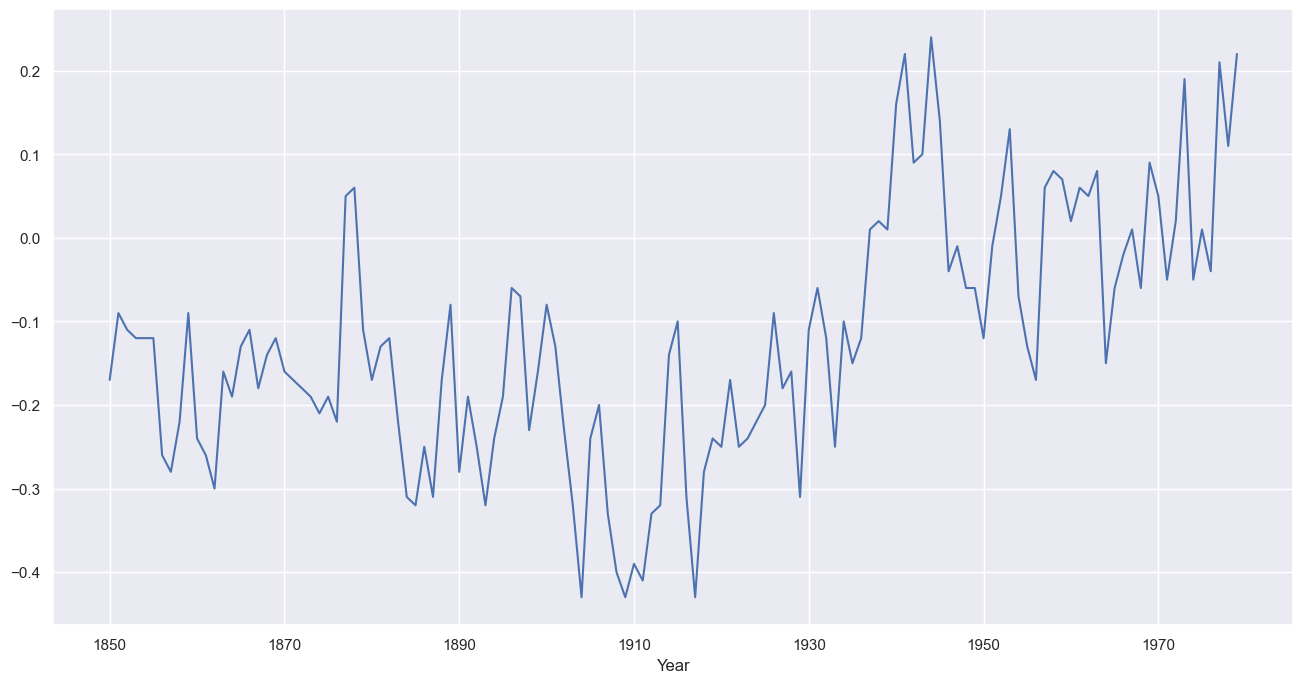

In [251]:
figsize = (16, 8)
train_df.set_index(time_col)[target_col].plot(figsize=figsize);

### **Train API**

Train data: convert df to list-of-list

In [252]:
train_data = []
for value in train_df.values:
    train_data.append(list(value))

In [253]:
train_data[:2]

[['1850', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.17],
 ['1851',
  0.00595381,
  0.0007451,
  0.00116604,
  -0.0009399,
  0.00064918,
  0.00065287,
  0.00064918,
  -4.97297e-06,
  0.0290878,
  -0.09]]

Custom Model Request (optional)

In [254]:
custom_model_request = {
    'type': 'meta_lr',
    'scorers': ['smape', 'mape'],
    'params': {
        'base_models': [
            {'type': 'darts_lightgbm'},
            #{'type': 'darts_autoarima'},
            {'type': 'darts_autotheta'},
            {'type': 'darts_autoets'},
            {'type': 'stats_autotheta'}
        ]
    }
}

Train API JSON Payload

In [255]:
api_json = {
    'data': train_data,
    'model': custom_model_request,
}

Build URL

In [256]:
with open('url.yaml', 'r') as file:
    url_dict = yaml.safe_load(file)

In [257]:
# URL to our SYBIL AWS service
protocol = url_dict["protocol"]
host = url_dict["host"]
port = url_dict["port"]
endpoint = "train"

url = "%s://%s:%s/%s" % (protocol, host, str(port), endpoint)

In [258]:
protocol, host, port

('http', 'localhost', 80)

Call endpoint, receive response JSON, write to output file

In [259]:
%%time
# TODO: gain a accredited cert and remove verify=False
response = requests.post(url, json=api_json, verify=False)

CPU times: total: 0 ns
Wall time: 585 ms


In [260]:
train_json_out = response.json()  # dict output
# train_json_out = json.dumps(response.json())  # str output
# train_json_out = json.dumps(response.json(), indent=4)  # str output w tabs

In [261]:
train_json_out

{'model': 'AgEBCA3MAQAIzAEAbmwBABgAAABlbAEAFC8AAD+AAC5wlGmUYXJhbG+MSZOMZ25fEmNpcoFtbmVhZ2ljch1dYWlibnhuZXNjNJR0cG1hY3RtYUuHCXQCUpT/dADAAB+UlF2FKC6HMv90tX3zx6fmo9yBlB9ohwkBAgMEBQYHCB8JlIYGfXNvlGVnjG5jCWFfZV9hBZRzbGxhaGmUc3JhlBAobGdwbGUPbJQAlIaUS07/icBY4IEAB5RLS12US1KU4ACRH5RSYWlkc19llGVlaGEujHVfQpRzcnSMbZOHTZRO/0MBAJSBER99S4YEfoiR6vT9B2Bpc33V3+nzS1VfacHL1d83QUtVrR+3wcojLTdAmaOstg8YIiyFjpii+gQOGCIsNT+Yoau1DR8XISuDjZeh+QMNF295g43l7/kCW2VveNHb5O5HUFpkvR/G0NoyPEZQqLK8xh4oMjyUnqiyChQeJ4CKk532AAkTbBZ1f4nh6/WUlIyGlGFfY2JpbJRueG59geEGnRAkKUtIAAC/vwAAv7/AaCGUS+EBgQo2fVGUaId0X2M2eOAMNghAPz8APz8/AD/gDzYfBRhlbHNNk4xvKERwgWFldHNzYmhlfXJydAtfX2+UdAofb3JycxBpc1OUCWl4ci5hYZSMcxRjaUlpKQWydHIuZ2EfbnJ9YZRoBmhflGSGcDx9akEAahqUaGgBAlJO/2KUUpQWjJROCGpPlG9pfWFyZWSUlHgouJQAlGjhAKjgcAAflLBzdGYJaUtflJRolLJfmwCBAQAkKUsAAFKUAWpiZXIfOnKUalJtQUtSAUJccMLr6+sKHsJw6wozR4UKwnAe60cfXHCFroXCmevCXArrwj1HAD1cRx6FAEfrhese10dHCtcfR7jrmVGZuI+jUUcemT24HusAXADrwplwcEc9wuvrAJkfM+tHR0dHwnCZ6x5HR+vr60eZCh4KXOtHHkfrmUcz60cfR+twmZlHh

### **Forecast API**

Forecast Dates: predict the next 2 years of air passenger data (1961-1962)

In [262]:
test_data = []
for value in test_df.drop(columns=target_col).values:
    test_data.append(list(value))

In [263]:
test_data[:2]

[['1980',
  2.09837,
  0.362496,
  0.132923,
  -0.197799,
  0.0534377,
  0.00195668,
  -0.116014,
  -0.557516,
  -0.0294989],
 ['1981',
  2.15487,
  0.37198,
  0.13994,
  -0.198391,
  0.0534899,
  0.00196222,
  -0.12073,
  -0.572096,
  -0.0378411]]

Model from Train API

In [264]:
model = train_json_out["model"]

Forecast API JSON Payload

In [265]:
api_json = {
    'model': model,
    'predicts': test_data
}

Build URL (same as train except for the endpoint)

In [266]:
endpoint = "forecast"

url = "%s://%s:%s/%s" % (protocol, host, str(port), endpoint)

Call endpoint, receive response JSON, write to output file

In [267]:
%%time
# TODO: gain a accredited cert and remove verify=False
response = requests.post(url, json=api_json, verify=False)

CPU times: total: 0 ns
Wall time: 180 ms


In [268]:
forecast_json_out = response.json()  # dict output
# forecast_json_out = json.dumps(response.json())  # str output
# forecast_json_out = json.dumps(response.json(), indent=4)  # str output w tabs

In [269]:
forecast_json_out

{'data': [['1980-01-01T00:00:00', 0.3698398200530042],
  ['1980-12-31T00:00:00', 0.7341579187048519],
  ['1981-12-31T00:00:00', 0.6832687962194253],
  ['1982-12-31T00:00:00', 0.6668695427533886],
  ['1983-12-31T00:00:00', 0.4625866104267118],
  ['1984-12-30T00:00:00', 0.828747390693841],
  ['1985-12-30T00:00:00', 0.7146624221272435],
  ['1986-12-30T00:00:00', 0.6332574904023136],
  ['1987-12-30T00:00:00', 0.49372648629911486],
  ['1988-12-29T00:00:00', 0.8620802970441603],
  ['1989-12-29T00:00:00', 0.7470011236723424],
  ['1990-12-29T00:00:00', 0.792138218828977],
  ['1991-12-29T00:00:00', 0.626692229452968],
  ['1992-12-28T00:00:00', 0.9783292048339798],
  ['1993-12-28T00:00:00', 0.8007527426465175],
  ['1994-12-28T00:00:00', 0.7802586998455083],
  ['1995-12-28T00:00:00', 0.6050607237366197],
  ['1996-12-27T00:00:00', 0.9679731884887361],
  ['1997-12-27T00:00:00', 0.8780157322293047],
  ['1998-12-27T00:00:00', 0.8694456089645961],
  ['1999-12-27T00:00:00', 0.6996262965050268],
  ['200

Combine forecast dates and output

In [270]:
forecast_df = pd.DataFrame(forecast_json_out["data"], columns = [time_col, target_col])

In [271]:
forecast_df.shape

(33, 2)

In [272]:
forecast_df.columns

Index(['Year', 'Anomaly'], dtype='object')

In [273]:
forecast_df.head()

,Year,Anomaly
0,1980-01-01T00:00:00,0.369840
1,1980-12-31T00:00:00,0.734158
2,1981-12-31T00:00:00,0.683269
3,1982-12-31T00:00:00,0.666870
4,1983-12-31T00:00:00,0.462587


In [274]:
forecast_df.tail()

,Year,Anomaly
28,2007-12-25T00:00:00,0.786102
29,2008-12-24T00:00:00,1.139009
30,2009-12-24T00:00:00,1.023682
31,2010-12-24T00:00:00,1.042825
32,2011-12-24T00:00:00,0.872121


Plot train and forecast side-by-side

C:\Users\User\AppData\Local\Temp\ipykernel_6532\28132996.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["color"] = "b"


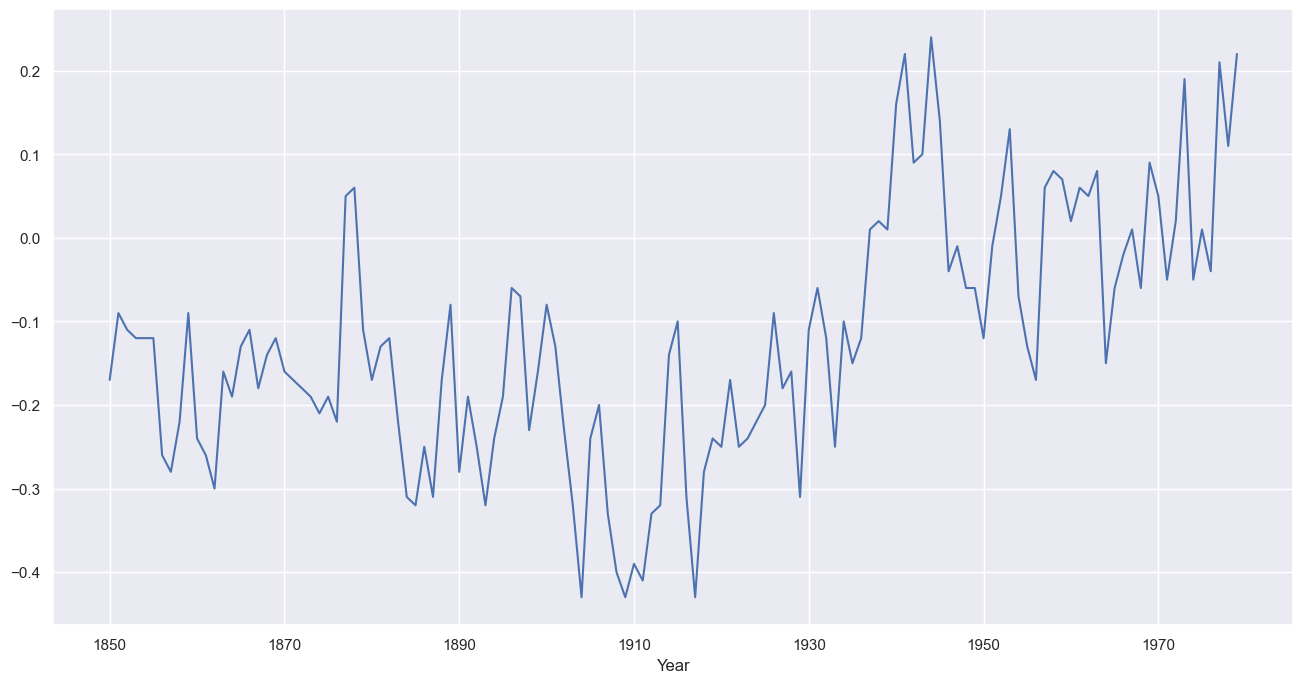

In [275]:
train_df["color"] = "b"
train_df.set_index(time_col)[target_col].plot(figsize=figsize, color=train_df["color"]);

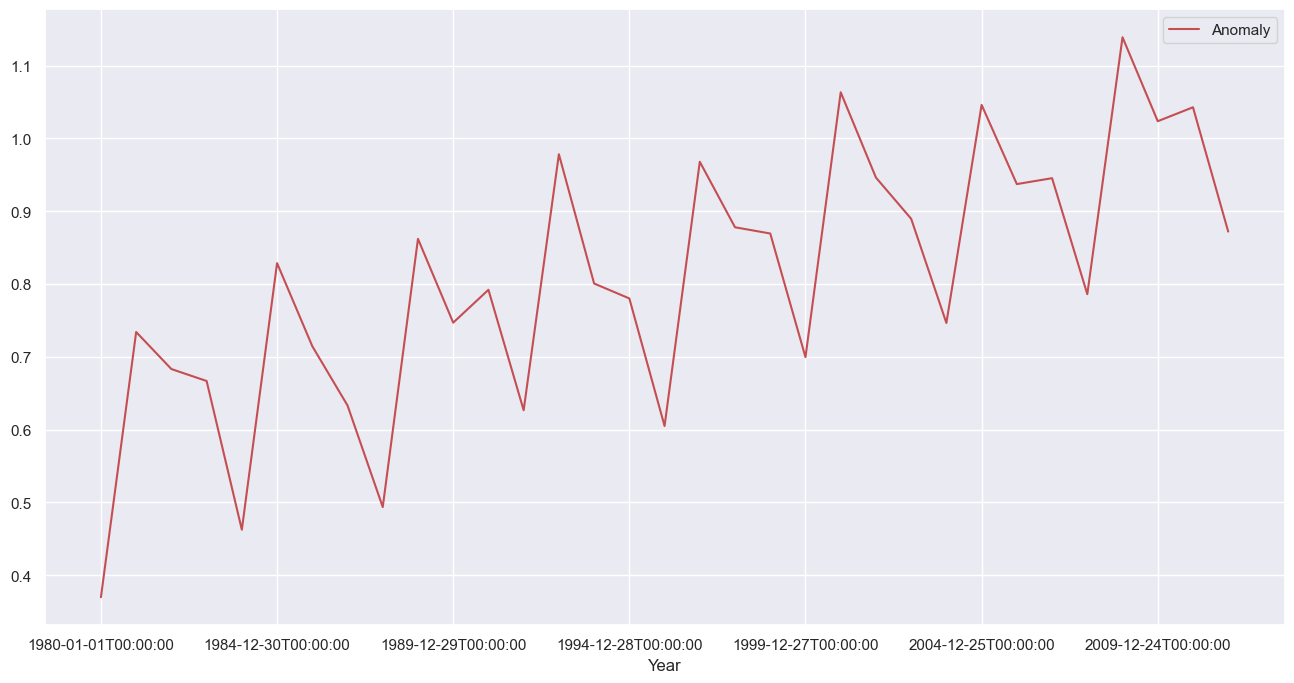

In [276]:
forecast_df["color"] = "r"
forecast_df.set_index(time_col).plot(figsize=figsize, color=forecast_df["color"]);

Combine train and test sets

In [277]:
df = pd.concat([train_df, forecast_df]).reset_index(drop=True)

In [278]:
df.shape

(163, 12)

In [279]:
df.head()

,Year,WMGHG,Ozone,Solar,Land_Use,SnowAlb_BC,Orbital,TropAerDir,TropAerInd,StratAer,Anomaly,color
0,1850,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.17,b
1,1851,0.005954,0.000745,0.001166,-0.000940,0.000649,0.000653,0.000649,-0.000005,0.029088,-0.09,b
2,1852,0.010502,0.000909,-0.010756,-0.002531,0.000649,0.000671,0.000649,-0.000005,0.056712,-0.11,b
3,1853,0.014587,0.001020,-0.027220,-0.004123,0.000649,0.000688,0.000649,-0.000005,0.077260,-0.12,b
4,1854,0.020521,0.001188,-0.045539,-0.005717,0.000649,0.000689,0.000649,-0.000005,0.085759,-0.12,b


In [280]:
df.tail()

,Year,WMGHG,Ozone,Solar,Land_Use,SnowAlb_BC,Orbital,TropAerDir,TropAerInd,StratAer,Anomaly,color
158,2007-12-25T00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.786102,r
159,2008-12-24T00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.139009,r
160,2009-12-24T00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.023682,r
161,2010-12-24T00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.042825,r
162,2011-12-24T00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.872121,r


Plot combined train and test sets with the vertical black line as the cut-off

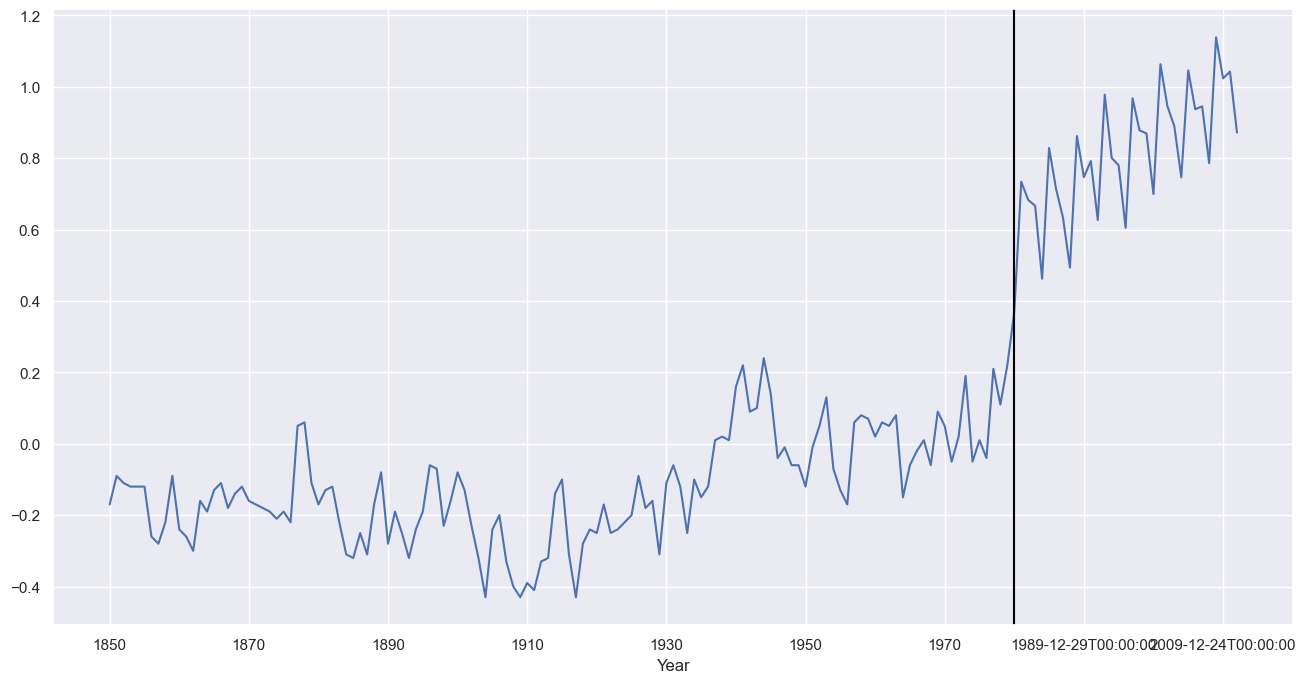

In [281]:
df.set_index(time_col)[target_col].plot(figsize=figsize, color=df["color"])
plt.axvline(x=len(train_df), color='black', label ='Train/Test set cut-off')
plt.show();